# Downstream Analysis

This notebook analyzes the cleaned Amazon Products dataset generated by our Airflow pipeline. We made visualizations and used clustering to uncover business insights regarding pricing, discounting, and customer satisfaction.


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [3]:
df = pd.read_csv('Amazon-Products.csv')
df.head(5)
#should explore about market trends (whats dominant), pricing strategy, insights about prod type
#

,name,main_category,sub_category,discount_price,actual_price,ratings,no_of_ratings,id
0,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,395.988,707.88,4.2,2255,1
1,LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,557.880,911.88,4.2,2948,2
2,LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Cop...,appliances,Air Conditioners,413.880,743.88,4.2,1206,3
3,LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,455.880,827.88,4.0,69,4
4,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,appliances,Air Conditioners,413.880,813.48,4.1,630,5


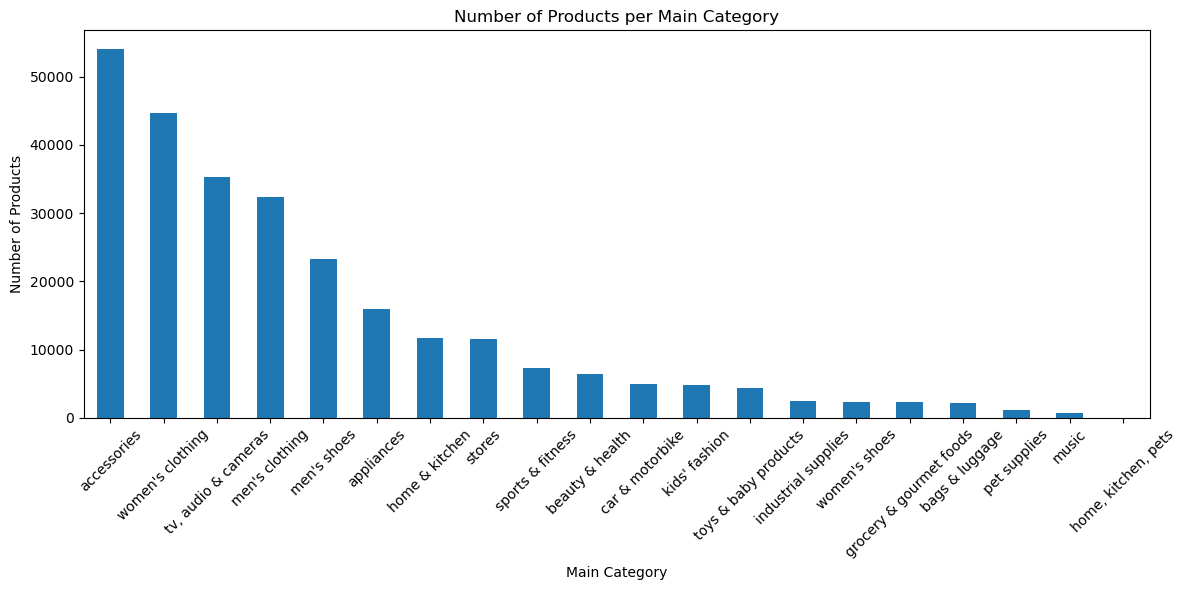

In [5]:
#products per main category, show market trends, inventory strategy, where products are most concentrated
plt.figure(figsize=(12,6))
df['main_category'].value_counts().plot(kind='bar')
plt.title('Number of Products per Main Category')
plt.xlabel('Main Category')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

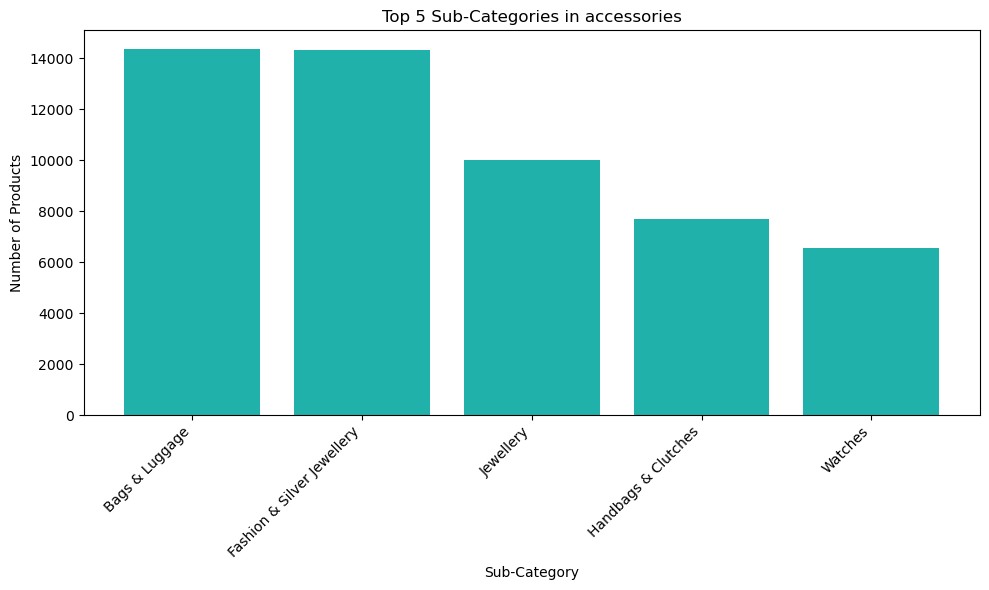

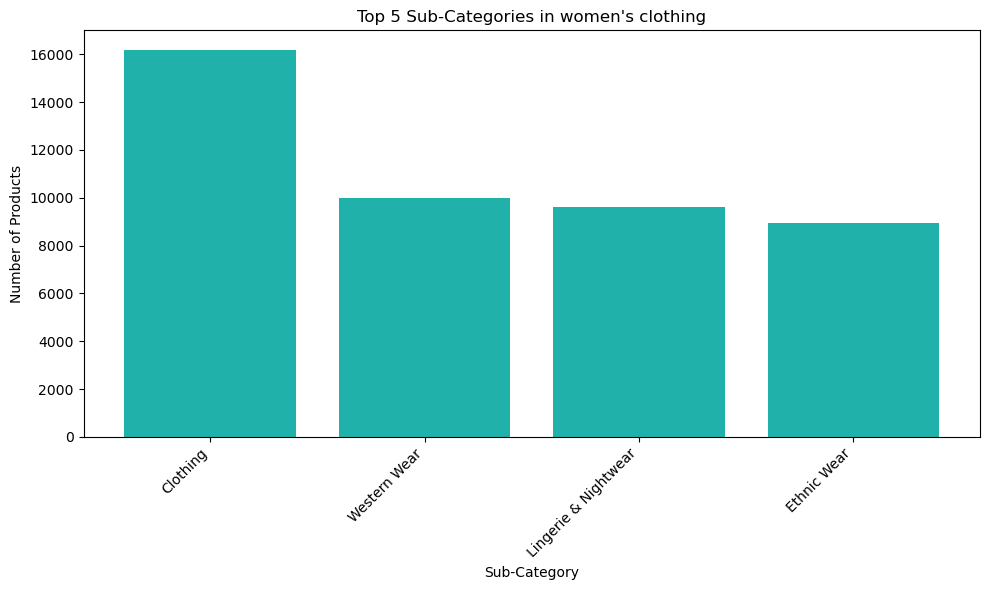

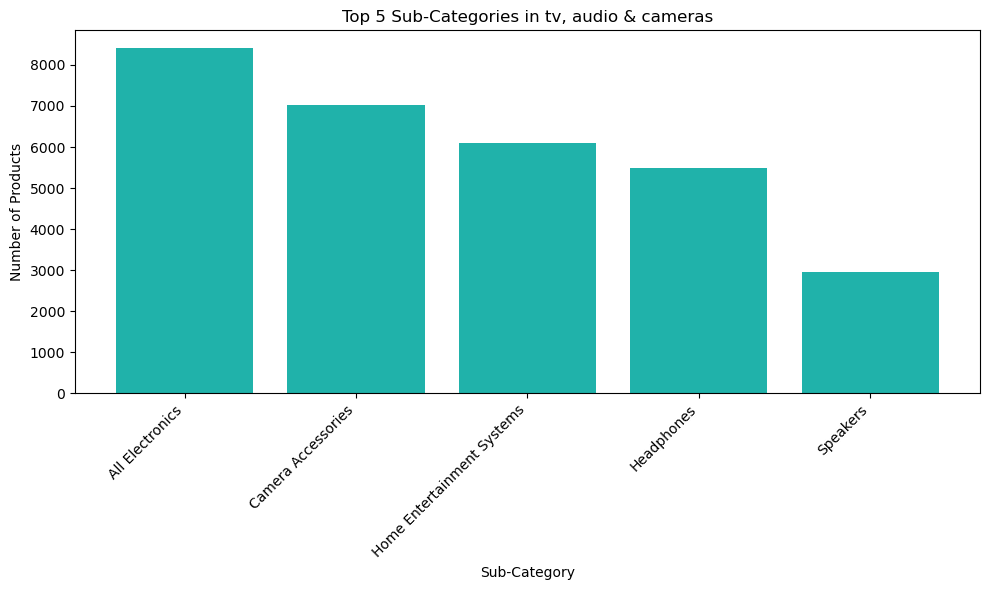

In [13]:
# Find top 3 main categories based on number of products
top3_main_categories = df['main_category'].value_counts().head(3).index

# Filter only rows in top 3 categories
filtered_df = df[df['main_category'].isin(top3_main_categories)]

# Group by main_category and sub_category
subcat_counts = filtered_df.groupby(['main_category', 'sub_category']).size().reset_index(name='counts')

# Plot for each main category
for category in top3_main_categories:
    temp = subcat_counts[subcat_counts['main_category'] == category]
    top5_subcats = temp.sort_values(by='counts', ascending=False).head(5)

    plt.figure(figsize=(10,6))
    plt.bar(top5_subcats['sub_category'], top5_subcats['counts'], color='lightseagreen')
    plt.title(f'Top 5 Sub-Categories in {category}')
    plt.ylabel('Number of Products')
    plt.xlabel('Sub-Category')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

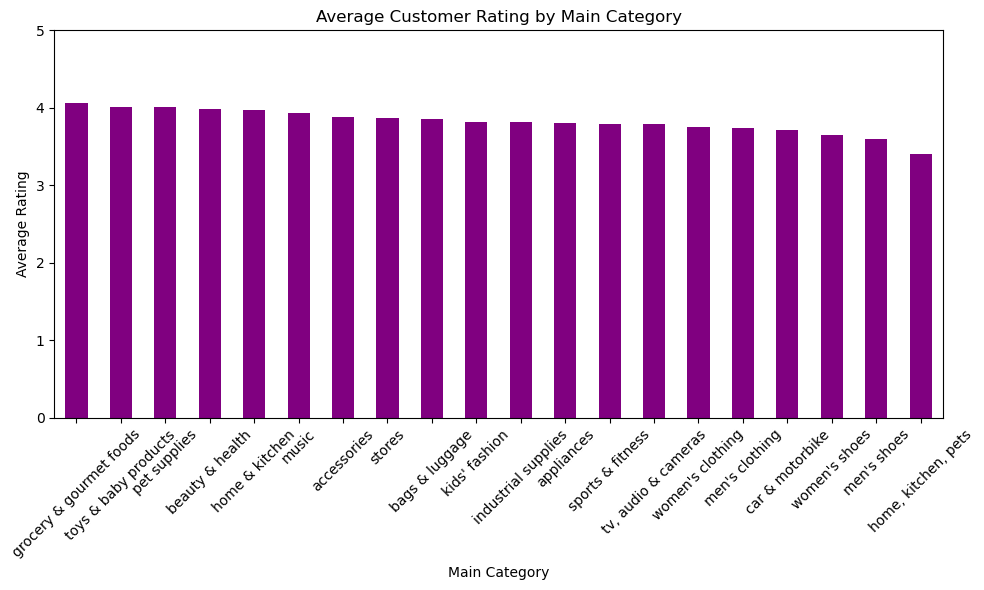

In [11]:
#avg rating for each main category
# Group by main_category and average ratings
avg_rating_by_category = df.groupby('main_category')['ratings'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,6))
avg_rating_by_category.plot(kind='bar', color='purple')
plt.title('Average Customer Rating by Main Category')
plt.ylabel('Average Rating')
plt.xlabel('Main Category')
plt.xticks(rotation=45)
plt.ylim(0,5)
plt.tight_layout()
plt.show()

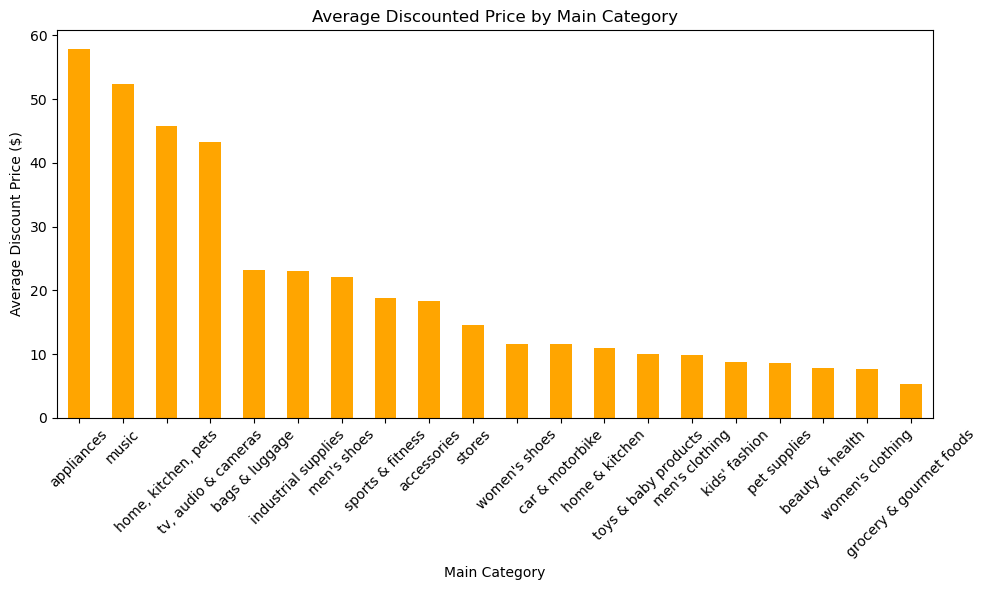

In [9]:
#avg discounted price per main category, how expesnive each category is --> affordability

avg_price_by_category = df.groupby('main_category')['discount_price'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,6))
avg_price_by_category.plot(kind='bar', color='orange')
plt.title('Average Discounted Price by Main Category')
plt.ylabel('Average Discount Price ($)')
plt.xlabel('Main Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

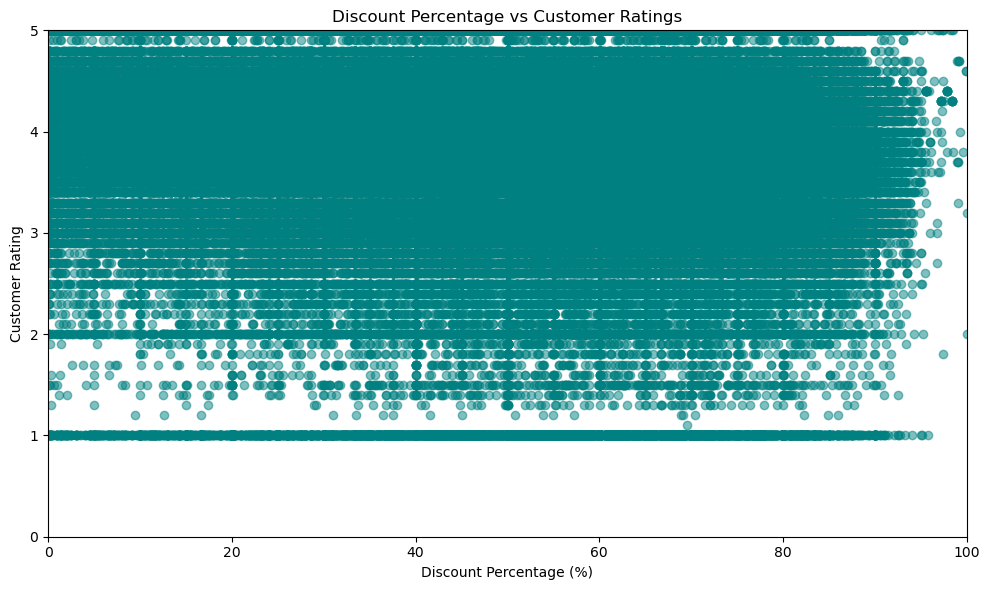

In [15]:
# Scatter plot of Discount Percentage vs Ratings --> no pattern between discount size and rating

plt.figure(figsize=(10,6))
plt.scatter(df['discount_percent'], df['ratings'], alpha=0.5, color='teal')
plt.title('Discount Percentage vs Customer Ratings')
plt.xlabel('Discount Percentage (%)')
plt.ylabel('Customer Rating')
plt.xlim(0, 100)  # Limit x-axis to 0–100% discounts
plt.ylim(0, 5)    # Ratings are from 0 to 5
plt.tight_layout()
plt.show()

now lets move onto some ML (unsupervised). We will use KNN to help group products that are similar. This can help us understand the structure of the product market, pricing/satisfaction strategies, and discounting effects on percieved values. Clustering will show "hidden types" of products based on factors.

/var/folders/nb/6sj7lmrs21x5k5j2btptxxsw0000gn/T/ipykernel_48608/321554103.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = clusters


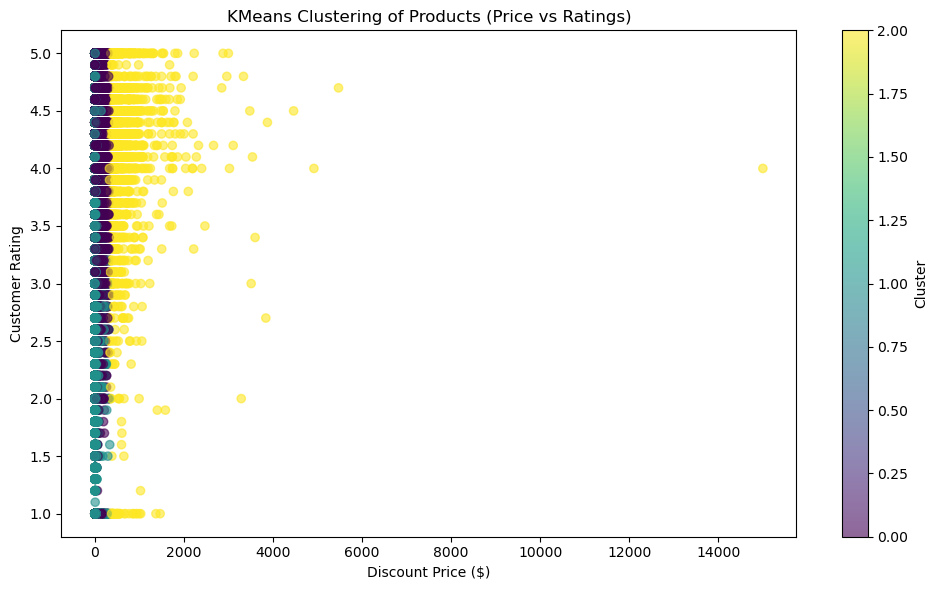

In [20]:
#select relevant features
X = df[['discount_price', 'ratings', 'discount_percent']]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add the cluster labels back to the original DataFrame
X['cluster'] = clusters

#plot
plt.figure(figsize=(10,6))
scatter = plt.scatter(X['discount_price'], X['ratings'], c=X['cluster'], cmap='viridis', alpha=0.6)
plt.title('KMeans Clustering of Products (Price vs Ratings)')
plt.xlabel('Discount Price ($)')
plt.ylabel('Customer Rating')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

we see a big vertical spread among y axis meaning that price doesn't dictate ratings. it depends on quality

In [21]:
#analyze
# Group by cluster and see average characteristics
cluster_summary = X.groupby('cluster').mean()
cluster_summary


,discount_price,ratings,discount_percent
cluster,,,
0,24.252310,4.119605,30.789700
1,9.599895,3.571758,64.574418
2,626.099928,4.130025,24.003616


We applied KMeans clustering on product pricing, discount behavior, and customer ratings, resulting in three distinct product segments:

Cluster 0 consists of affordable products (~$24 average price) that maintain high customer satisfaction (4.12/5) with moderate discounting. These are budget-friendly items delivering good value.

Cluster 1 includes extremely cheap products (~$9.60) that are heavily discounted (average 64% off) but have lower customer satisfaction (3.57/5). This indicates that heavy discounting is not enough to compensate for lower product quality.

Cluster 2 contains premium, expensive products (~$626 average price) with high customer satisfaction (4.13/5) and lower discount percentages (24%). These products demonstrate strong brand or quality-driven loyalty among customers, even without major price cuts.

Overall, the clustering revealed that customer satisfaction is not strongly linked to discount size but correlates more closely with product quality and value perception.

***Suggestions***

0 =	Affordable + Good Quality	Focus on value marketing

1 = Very Cheap + Lower Quality	Improve product quality or reposition branding


2 = Expensive + High Quality	Maintain premium positioning, no need for heavy discounting